In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
np.random.seed(0)

In [2]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [3]:
def cross_dot(b):
    # d(axb)/d(a)
    cross_dot = np.array([[0, b[2], -b[1]],
                    [-b[2], 0, b[0]],
                    [b[1], -b[0], 0]])
    return cross_dot

def cross2_dot(a, b):
    #d(ax(axb))/d(a)
    cross2_dot = np.array([[a[1]*b[1]+a[2]*b[2], a[0]*b[1]-2*a[1]*b[0], a[0]*b[2]-2*a[2]*b[0]],
                           [-2*a[0]*b[1]+a[1]*b[0], a[0]*b[0]+a[2]*b[2], a[1]*b[2]-2*a[2]*b[1]],
                           [-2*a[0]*b[2]+a[2]*b[0], -2*a[1]*b[2]+a[2]*b[1], a[0]*b[0]+a[1]*b[1]]])
    return cross2_dot
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [4]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus):
    state_next = np.zeros(9+6*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = a_input_noise * np.random.randn(3)                               # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    return state_next

def dynamics_est(dt, state, num_imus):
    state_next = np.zeros((state.shape))
    state_next[0:3] = state[0:3] + state[3:6] * dt          # omega
    state_next[3:6] = np.zeros(3)                           # omega_dot
    state_next[6:9] = state[6:9]                            # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus]      # Rate random walk state
    return state_next

def Jacobian_f(dt, num_imus):
    F = np.zeros((9+6*num_imus, 9+6*num_imus))
    F[0:3, 0:3]            = np.eye(3)
    F[0:3, 3:6]            = dt * np.eye(3)
    F[9:9+6*num_imus, 9:9+6*num_imus] = np.eye(6*num_imus)
    return F

In [5]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        omega = state[0:3]
        omega_dot = state[3:6]
        sf = state[6:9]
        RW_sub = state[9+i*6:15+6*i]
        omega_i = Rb_si_sub @ omega + WN[i*6:i*6+3]*np.random.randn(3) + RW_sub[0:3]
        sf_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*6+3:(i+1)*6]*np.random.randn(3)) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((omega_i, sf_i)) # omega, specific force
    return meas

def measurement_est(state, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    H = np.zeros((6*num_imus, 9+6*num_imus))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        omega = state[0:3]
        omega_dot = state[3:6]
        sf = state[6:9]
        RW_sub = state[9+i:15+6*i]
        H_i = np.zeros((6, 9+6*num_imus))
        H_i[0:3, 0:3] = Rb_si_sub @ cross2_dot(omega, r_sub)
        H_i[0:3, 3:6] = Rb_si_sub @ cross_dot(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[0:3, 12+i*6:15+i*6] = np.eye(3)
        H_i[3:6, 0:3] = Rb_si_sub
        H_i[3:6, 9+i*6:12+i*6] = np.eye(3)
        meas[i*6:6+i*6] = H_i @ state
        H[i*6:6+i*6, :] = H_i
    return meas, H

In [6]:
# measurements
measurements = np.array(read_txt("../data/imu.txt"))

In [7]:
num_imus = 3

# randomly generate position arrangement of IMUs
Rb = []
pos = []
for j in range(num_imus):
    pos.append(np.random.rand(3)) # position of jth imu in DISIMU
    Rb.append(np.eye(3)) # orientation of jth imu in DISIMU
pos_r = np.asarray(pos)
Rb_si = np.asarray(Rb)

w_input_noise = 1e-3
a_input_noise = 1e-3

# parameters from datasheet
gyroscope_wn = 0.002 # degrees / s / sqrt(Hz)
accelerometer_wn = 0.016 # m / s^2 / sqrt(Hz)
gyroscope_arw = 0.09 # degrees / sqrt(Hr)
accelerometer_vrw = 0.008 # m / s / sqrt(Hr)
WN = np.hstack((gyroscope_wn*np.ones(3*num_imus), accelerometer_wn*np.ones(3*num_imus)))
RW = np.hstack((gyroscope_arw*np.ones(3*num_imus), accelerometer_vrw*np.ones(3*num_imus)))

dt = 1e-2
time = np.arange(0, 360, dt)

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9 + 6*num_imus)
state_est = np.zeros(9 + 6*num_imus)
omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 10]) # assuming 10 m/s^2 for gravity
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9 + 6*num_imus))
state_est_hist = np.zeros((len(time), 9 + 6*num_imus))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Initial state Coveriance
P_est = np.eye(9 + 6*num_imus)

# Covariance of process noise covariance
Q = np.zeros((9 + 6*num_imus, 9 + 6*num_imus))
Q[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
Q[6:9,6:9] = a_input_noise ** 2 * np.eye(3)
Q[9:9+6*num_imus, 9:9+6*num_imus] = np.diag(RW**2)

# Covariance of measurement noise covariance
R = np.eye(6*num_imus)*WN**2

for i in trange(len(time)):
    state = dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus)
    state_hist[i] = state
    # Prediction step
    state_pred = dynamics_est(dt, state_est, num_imus)
    F = Jacobian_f(dt, num_imus)
    P_pred = np.dot(np.dot(F, P_est), F.T) + Q

    # Update step
    meas, H = measurement_est(state_pred, pos_r, Rb_si, num_imus)
    y = measurements[i] - meas
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    state_est = state_pred + np.dot(K, y)
    P_est = np.dot(np.eye(len(P_est))- np.dot(K,H), P_pred)
    meas_hist[i] = meas
    state_est_hist[i] = state_est

100%|██████████| 36000/36000 [00:48<00:00, 737.71it/s] 


DISIMU omega hat: quantization    6.123863e-08
white           1.379177e-06
flicker         0.000000e+00
walk            1.287338e-07
ramp            0.000000e+00
Name: 0, dtype: float64, quantization    8.944635e-07
white           1.282400e-06
flicker         9.739013e-08
walk            0.000000e+00
ramp            1.768396e-08
Name: 0, dtype: float64, quantization    1.639721e-06
white           1.058536e-06
flicker         0.000000e+00
walk            1.021552e-07
ramp            1.150790e-08
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

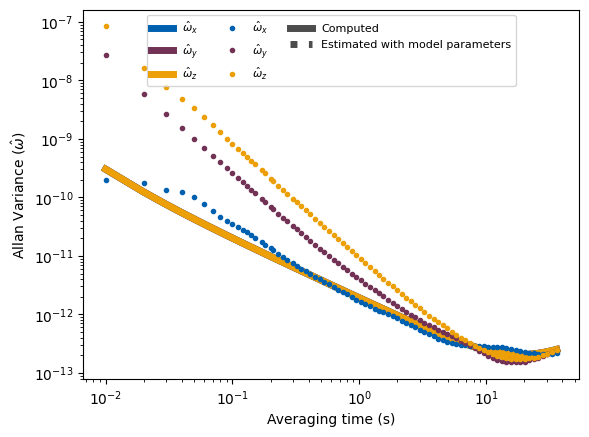

In [8]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wx, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wx, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.000000
white           0.000000
flicker         0.065025
walk            0.850623
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000108
white           0.003227
flicker         0.000000
walk            0.913486
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000198
white           0.000000
flicker         0.047353
walk            0.878415
ramp            0.102463
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.000000
white           0.000000
flicker         0.065092
walk            0.833313
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000184
white           0.000000
flicker         0.029545
walk            0.895983
ramp            0.019563
Name: 0, dtype: float64, quantization    0.000267
white           0.000000
flicker         0.000000
walk            0.922110
ramp            0.000000
Name: 0, dtype: float64
IMU 3 SF hat: quantization    0.000000
white           0.000000
flicker   

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

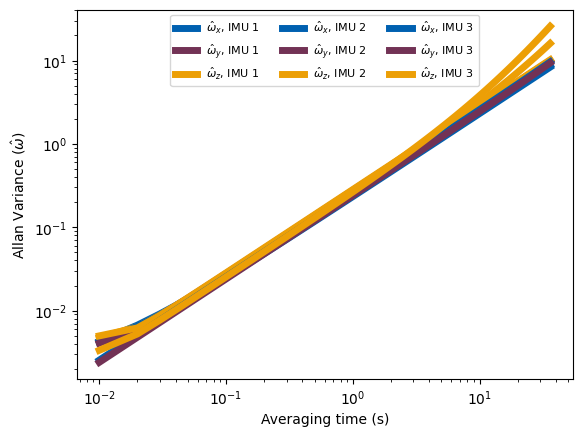

In [9]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

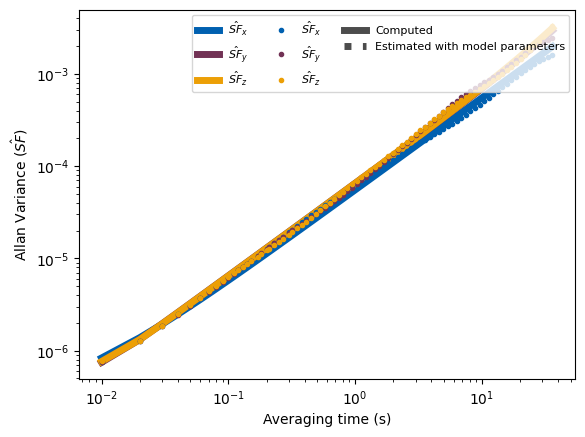

In [10]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.000015
white           0.000000
flicker         0.004555
walk            0.078207
ramp            0.004487
Name: 0, dtype: float64, quantization    0.000000
white           0.000387
flicker         0.000000
walk            0.079515
ramp            0.011339
Name: 0, dtype: float64, quantization    0.000021
white           0.000000
flicker         0.000000
walk            0.081798
ramp            0.002305
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.000062
white           0.000980
flicker         0.009178
walk            0.077351
ramp            0.005012
Name: 0, dtype: float64, quantization    0.000012
white           0.001561
flicker         0.000000
walk            0.080550
ramp            0.000000
Name: 0, dtype: float64, quantization    0.000072
white           0.000000
flicker         0.014206
walk            0.070077
ramp            0.000000
Name: 0, dtype: float64/n
IMU 3 SF hat: quantization    0.000008
white           0.000295
flicke

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

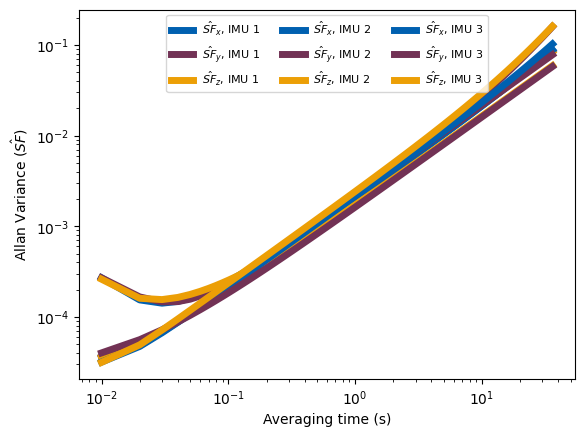

In [11]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0, 0.5, '$\\hat{\\omega}$ ($^{o}/s$)')

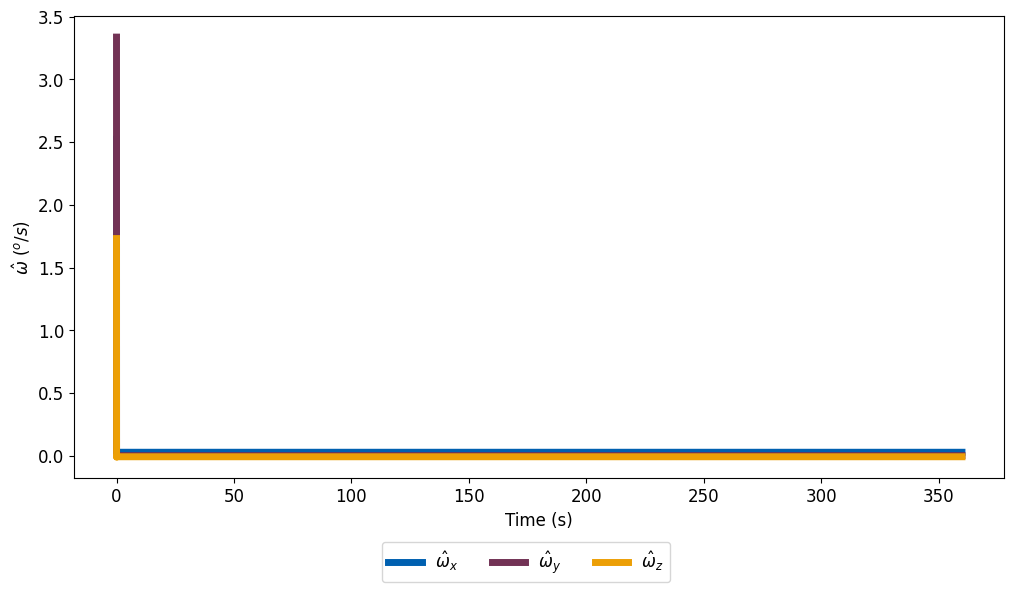

In [12]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ ($^{o}/s$)", fontsize=12)

Text(0.5, 0, 'Time (s)')

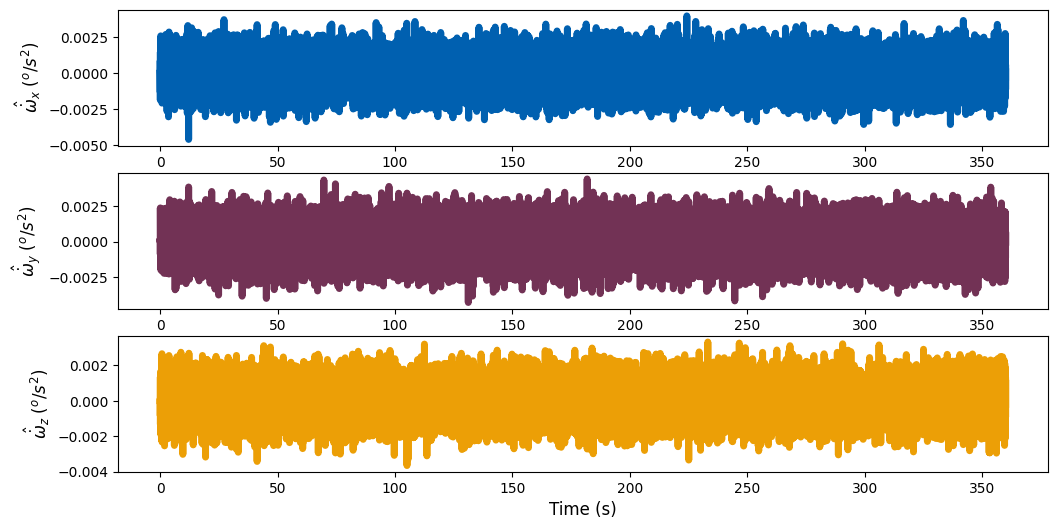

In [13]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,3])
# plt.plot(time, state_est_hist[:,4])
# plt.plot(time, state_est_hist[:,5])
# plt.title("omega dot")

fig2, ax2 = plt.subplots(3, 1, figsize = (12, 6))
ax2[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
# ax2[0].set_ylim([-0.0005, 0.0005])
# ax2[1].set_ylim([-0.0005, 0.0005])
# ax2[2].set_ylim([-0.0005, 0.0005])
ax2[0].set_ylabel("$\hat{\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1].set_ylabel("$\hat{\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2].set_ylabel("$\hat{\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

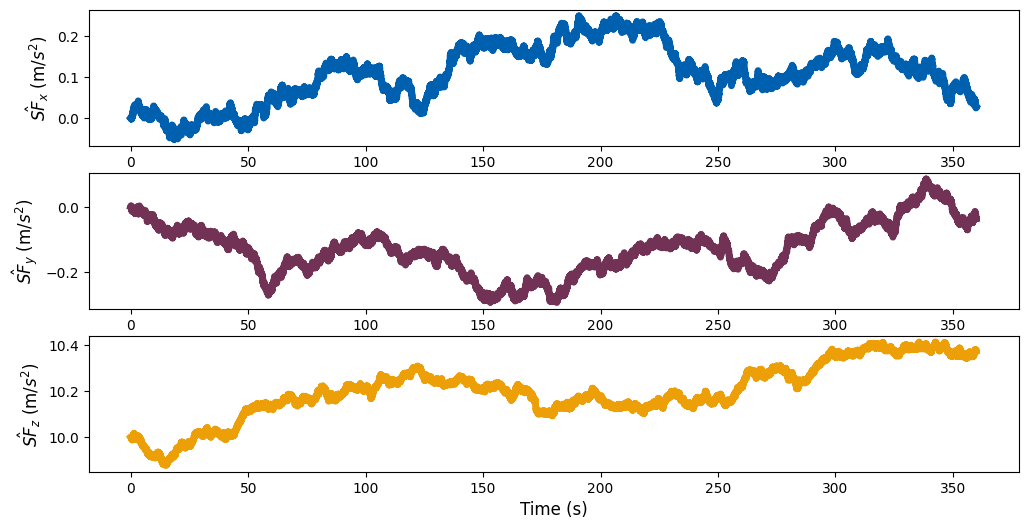

In [14]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,6])
# plt.plot(time, state_est_hist[:,7])
# plt.plot(time, state_est_hist[:,8])
# plt.title("specific force")

fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax3[1].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax3[2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
# ax3[0].set_ylim([-0.005, 0.005])
# ax3[1].set_ylim([-0.005, 0.005])
# ax3[2].set_ylim([-0.005, 0.005])
ax3[0].set_ylabel("$\hat{SF}_x$ (m/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{SF}_y$ (m/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{SF}_z$ (m/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0, 0.5, '$\\omega$ ($^{o}/s$)')

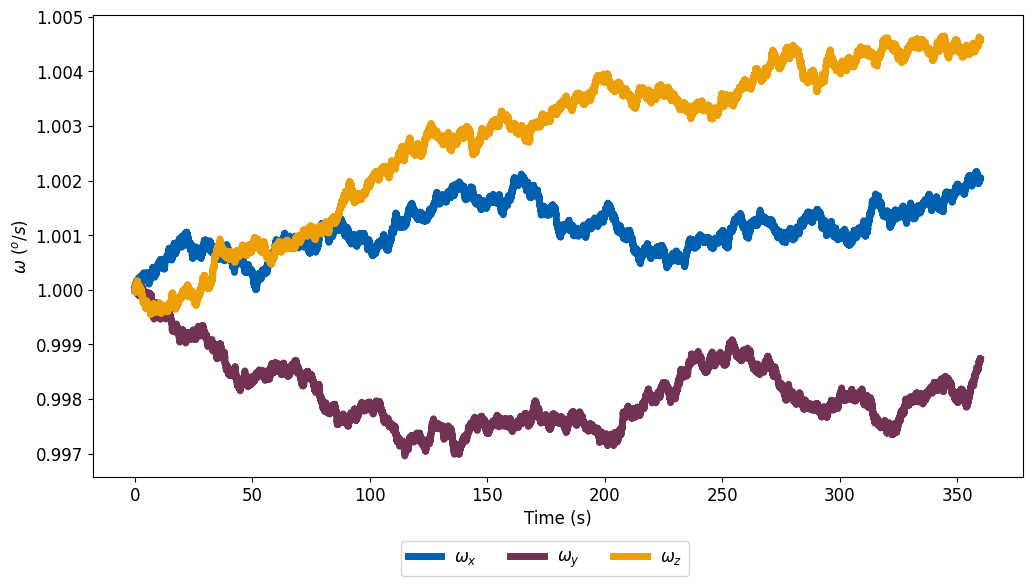

In [15]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,0])
# plt.plot(time, state_hist[:,1])
# plt.plot(time, state_hist[:,2])
# plt.title("omega")

fig4, ax4 = plt.subplots(figsize = (12, 6))
ax4.plot(time[10:], state_hist[10:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax4.plot(time[10:], state_hist[10:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax4.plot(time[10:], state_hist[10:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax4.set_xlabel("Time (s)", fontsize=12)
# ax4.set_ylim([1-0.005, 1+0.005])
ax4.set_ylabel("$\omega$ ($^{o}/s$)", fontsize=12)

Text(0.5, 0, 'Time (s)')

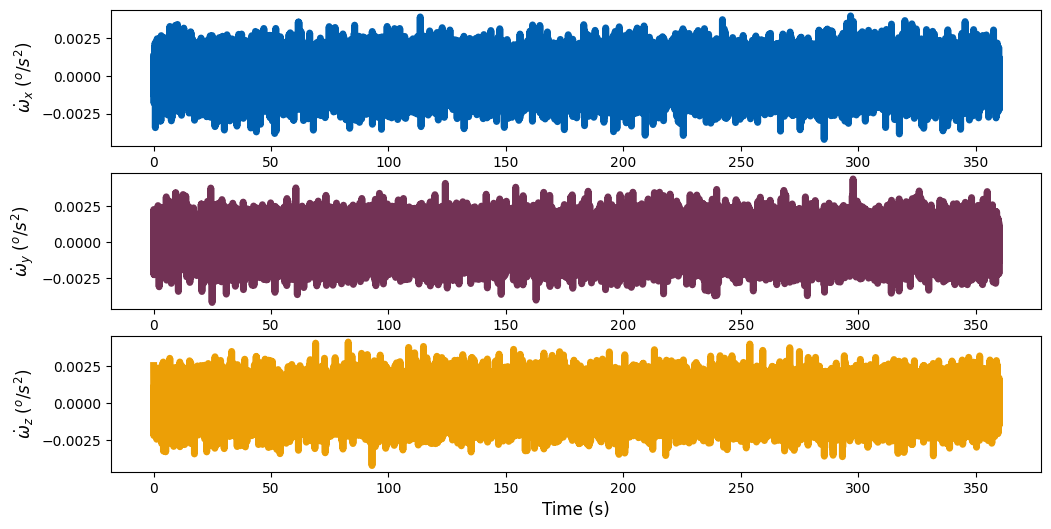

In [16]:
# system, omega hat dot
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,3])
# plt.plot(time, state_hist[:,4])
# plt.plot(time, state_hist[:,5])
# plt.title("omega dot")

fig5, ax5 = plt.subplots(3, 1, figsize = (12, 6))
ax5[0].plot(time, state_hist[:,3], linewidth=5, color = "#0060B0", label = "$\dot{\omega}_x$")
ax5[1].plot(time, state_hist[:,4], linewidth=5, color = "#723255", label = "$\dot{\omega}_y$")
ax5[2].plot(time, state_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\dot{\omega}_z$")
ax5[0].set_ylabel("$\dot{\omega}_x$ ($^{o}/s^2$)", fontsize=12)
ax5[1].set_ylabel("$\dot{\omega}_y$ ($^{o}/s^2$)", fontsize=12)
ax5[2].set_ylabel("$\dot{\omega}_z$ ($^{o}/s^2$)", fontsize=12)
ax5[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

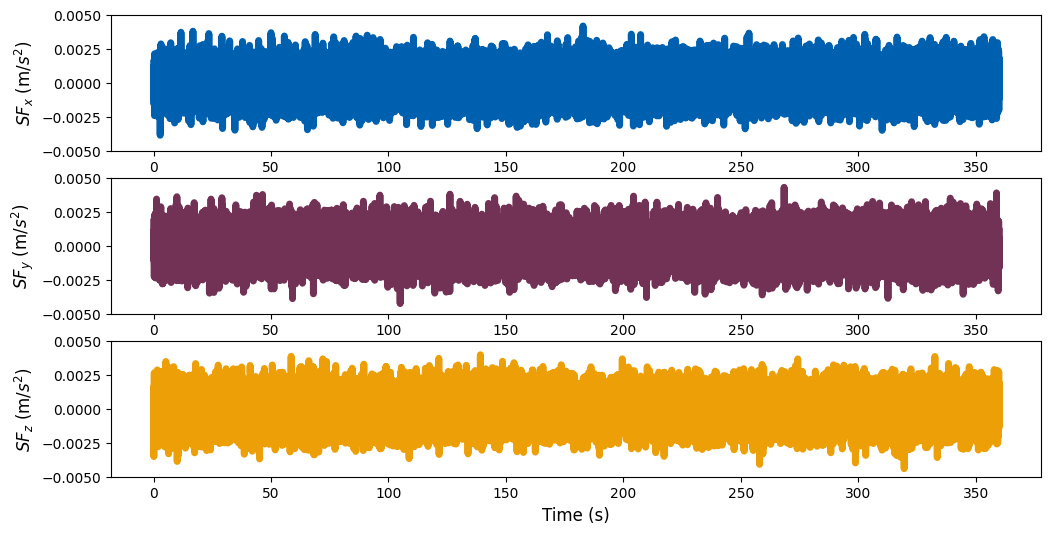

In [17]:
# dynamics, SF
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,6])
# plt.plot(time, state_hist[:,7])
# plt.plot(time, state_hist[:,8])
# plt.title("specific force")

fig6, ax6 = plt.subplots(3, 1, figsize = (12, 6))
ax6[0].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$SF_x$")
ax6[1].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$SF_y$")
ax6[2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$SF_z$")
# ax3[0].set_ylim([-0.0025, 0.0025])
# ax3[1].set_ylim([-0.0025, 0.0025])
# ax3[2].set_ylim([-0.0025, 0.0025])
ax6[0].set_ylim([-0.005, 0.005])
ax6[1].set_ylim([-0.005, 0.005])
ax6[2].set_ylim([-0.005, 0.005])
ax6[0].set_ylabel("$SF_x$ (m/$s^2$)", fontsize=12)
ax6[1].set_ylabel("$SF_y$ (m/$s^2$)", fontsize=12)
ax6[2].set_ylabel("$SF_z$ (m/$s^2$)", fontsize=12)
ax6[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

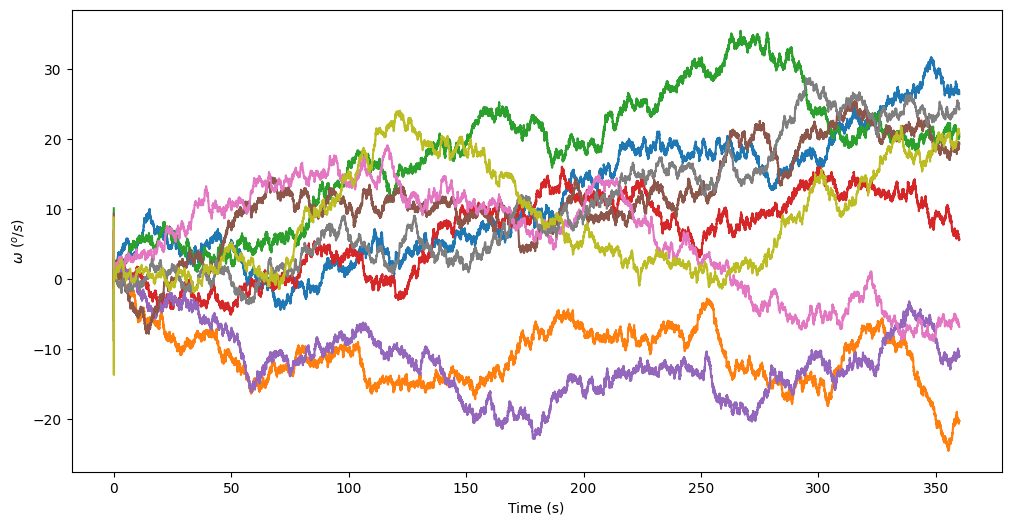

In [18]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

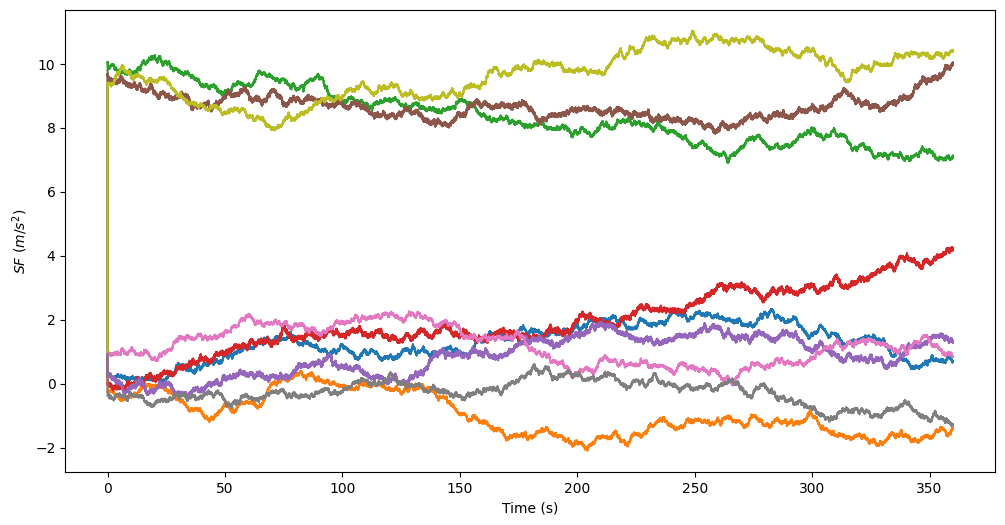

In [19]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")